# Exercise 3: Multi-class Classification and Neural Networks

In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits. Before starting the programming
exercise, we strongly recommend watching the video lectures and completing
the review questions for the associated topics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# load .mat file
from scipy.io import loadmat
from scipy import optimize
import os
import utils

## 1. Multi-class Classificatiton

For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this
classification task.

In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset

In [2]:
# import data
data = loadmat("./input/ex3data1.mat") #dict

In [3]:
X, y = data['X'], data['y']
# numpy.ndarray
# X.shape # 5000 samples, 400 parameters
# y.shape # 5000,1

In [4]:
y[y==10] = 0
y

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

### 1.2 Visualizing the data

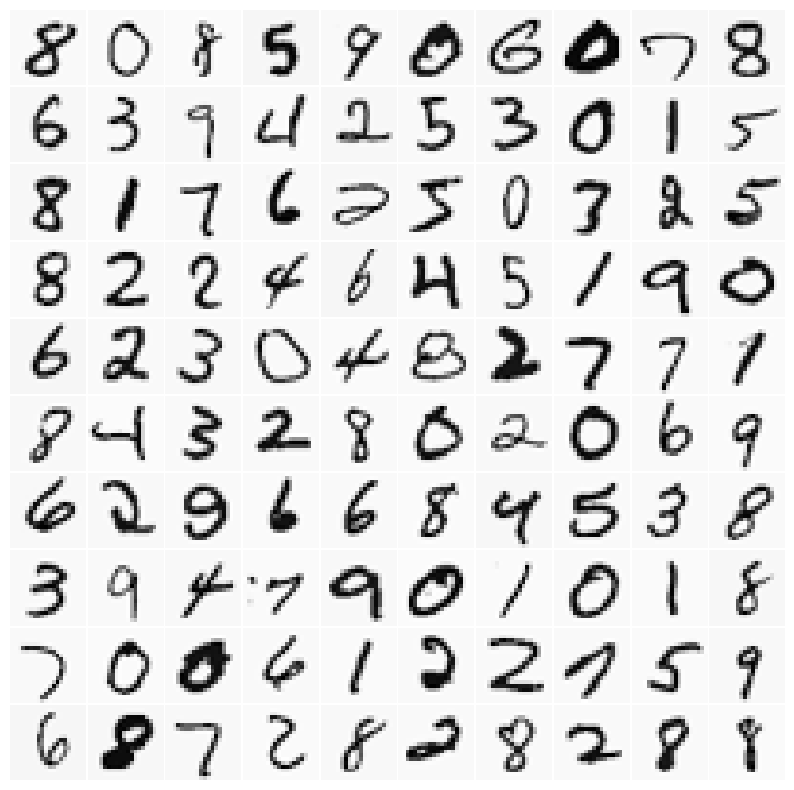

In [5]:
# randomly choose 100 data to display
rand_index = np.random.choice(y.size, 100, replace=False)
sel = X[rand_index,]
utils.displayData(sel)

### 1.3 Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

$J(\theta) = \frac{1}{m}\Sigma^{m}_{i=1}[-y^{(i)}log(h_{\theta}(x^{(i)}))-(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m}\Sigma^n_{k=1}\theta^2_k$

$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m}\Sigma^{m}_{i=1}(h_{\theta}(x^{(i)}) - y(i))x_j^{(i)}$ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j}=(\frac{1}{m}\Sigma^{m}_{i=1}(h_{\theta}(x^{(i)}) - y(i))x_j^{(i)})+\frac{\lambda}{m}\theta_j$ for $j\geq1$

__NOTE: In this section, I define data type and dimension of inputs as follow:__

- X: input variables

As data is loaded using the `scipy.io.loadmat` function, the loaded data is a 2D numpy ndarray type\
Shape of the 2d array: (`number of data entries (m)`, `number of features (n)`)\
deal with that

- y: output variables

The data loaded is actually of shape (`number of data entries (m)`, `1`)\
It behaves differently than a ndarray of shape (`number of data entries (m)`, ) (without the `1`), this actually causes many trouble when I first worked on this\
I define the output variables as a ndarray data type of shape (`number of data entries (m)`, `1`), as it is more strict and causes less error.

- theta: initial parameters

For now, theta takes a ndarray of shape (`number of data entries (m)`, )\
It will be reshaped within the function, and I will make theta of shape (`number of data entries (m)`, `1`) IN THE FUTURE

- lambda_: regularization parameter

integer, thank you

In [6]:
def lrCostFunction(theta, X, y, lambda_):
    """
    Computes the cost of using theta as the parameter for regularized
    logistic regression and the gradient of the cost w.r.t. to the parameters.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept.  
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (including intercept).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta
    
    Hint 1
    ------
    The computation of the cost function and gradients can be efficiently
    vectorized. For example, consider the computation
    
        sigmoid(X * theta)
    
    Each row of the resulting matrix will contain the value of the prediction
    for that example. You can make use of this to vectorize the cost function
    and gradient computations. 
    
    Hint 2
    ------
    When computing the gradient of the regularized cost function, there are
    many possible vectorized solutions, but one solution looks like:
    
        grad = (unregularized gradient for logistic regression)
        temp = theta 
        temp[0] = 0   # because we don't add anything for j = 0
        grad = grad + YOUR_CODE_HERE (using the temp variable)
    
    Hint 3
    ------
    We have provided the implementatation of the sigmoid function within 
    the file `utils.py`. At the start of the notebook, we imported this file
    as a module. Thus to access the sigmoid function within that file, you can
    do the following: `utils.sigmoid(z)`.
    
    """
    #Initialize some useful values
    m = y.size
    
    # convert labels to ints if their type is bool
    if y.dtype == bool:
        y = y.astype(int)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ====================== YOUR CODE HERE ======================
    theta_reg = theta.copy().reshape(X.shape[1], 1)
    theta_reg[0] = 0
    h_x = (utils.sigmoid(X @ theta)).reshape(m,1)
    J = ((-y.T @ np.log(h_x)) - ((1 - y).T @ np.log(1 - h_x))) / m + lambda_ / (2 * m) * (theta_reg.T @ theta_reg)
    grad = (X.T @ (h_x - y)) / m + theta_reg * lambda_ / m
    # =============================================================
    return sum(sum(J)), grad.reshape(theta.shape)

In [7]:
# test values for the parameters theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# test values for the inputs
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# test values for the labels
y_t = np.array([1, 0, 1, 0, 1]).reshape(5,1)

# test value for the regularization parameter
lambda_t = 3

J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)
# print(J)
# print(grad)
# m,n = X_t.shape
# h_x_t = utils.sigmoid(X_t @ theta_t).reshape(m,1)
# X_t.T @ (h_x_t - y_t) + theta_t.reshape(X_t.shape[1], 1)
print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


### 1.4 One-vs-all Classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the `K` classes in our dataset. In the handwritten digits dataset, `K=10`, but your code should work for any value of `K`.

In [8]:
def oneVsAll(X, y, num_labels, lambda_):
    """
    Trains num_labels logistic regression classifiers and returns
    each of these classifiers in a matrix all_theta, where the i-th
    row of all_theta corresponds to the classifier for label i.
    
    Parameters
    ----------
    X : array_like
        The input dataset of shape (m x n). m is the number of 
        data points, and n is the number of features. Note that we 
        do not assume that the intercept term (or bias) is in X, however
        we provide the code below to add the bias term to X. 
    
    y : array_like
        The data labels. A vector of shape (m, ).
    
    num_labels : int
        Number of possible labels.
    
    lambda_ : float
        The logistic regularization parameter.
    
    Returns
    -------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        (ie. `numlabels`) and n is number of features without the bias.
    
    Instructions
    ------------
    You should complete the following code to train `num_labels`
    logistic regression classifiers with regularization parameter `lambda_`. 
    
    Hint
    ----
    You can use y == c to obtain a vector of 1's and 0's that tell you
    whether the ground truth is true/false for this class.
    
    Note
    ----
    For this assignment, we recommend using `scipy.optimize.minimize(method='CG')`
    to optimize the cost function. It is okay to use a for-loop 
    (`for c in range(num_labels):`) to loop over the different classes.
    
    Example Code
    ------------
    
        # Set Initial theta
        initial_theta = np.zeros(n + 1)
      
        # Set options for minimize
        options = {'maxiter': 50}
    
        # Run minimize to obtain the optimal theta. This function will 
        # return a class object where theta is in `res.x` and cost in `res.fun`
        res = optimize.minimize(lrCostFunction, 
                                initial_theta, 
                                (X, (y == c), lambda_), 
                                jac=True, 
                                method='TNC',
                                options=options) 
    """
    # Some useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    options = {"maxfun": 50}
    for k in range(num_labels):
        res = optimize.minimize(lrCostFunction,
                                all_theta[k],
                                (X, (y==k).astype(int), lambda_),
                                jac=True,
                                method="TNC",
                                options=options
                               )
        all_theta[k] = res.x
    # ============================================================
    return all_theta

In [9]:
lambda_ = 0.1
all_theta = oneVsAll(X, y, 10, lambda_)
## test numpy 2d array dimension stuff : )
# theta = np.arange(X.shape[1])
# # ((X @ theta).reshape(5000,1) - y).shape
# (utils.sigmoid(X @ theta) - y).shape
# # X.T.shape

#### 1.4.1 One-vs-all Prediction

After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regression classifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (0, 1, ..., K-1) as the prediction for the input example. You should now complete the code in the function `predictOneVsAll` to use the one-vs-all classifier for making predictions.

In [10]:
def predictOneVsAll(all_theta, X):
    """
    Return a vector of predictions for each example in the matrix X. 
    Note that X contains the examples in rows. all_theta is a matrix where
    the i-th row is a trained logistic regression theta vector for the 
    i-th class. You should set p to a vector of values from 0..K-1 
    (e.g., p = [0, 2, 0, 1] predicts classes 0, 2, 0, 1 for 4 examples) .
    
    Parameters
    ----------
    all_theta : array_like
        The trained parameters for logistic regression for each class.
        This is a matrix of shape (K x n+1) where K is number of classes
        and n is number of features without the bias.
    
    X : array_like
        Data points to predict their labels. This is a matrix of shape 
        (m x n) where m is number of data points to predict, and n is number 
        of features without the bias term. Note we add the bias term for X in 
        this function. 
    
    Returns
    -------
    p : array_like
        The predictions for each data point in X. This is a vector of shape (m, ).
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned logistic
    regression parameters (one-vs-all). You should set p to a vector of predictions
    (from 0 to num_labels-1).
    
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index 
    of the max for each row.
    """
    m = X.shape[0];
    num_labels = all_theta.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(m)
    p_ = np.zeros(m)

    # Add ones to the X data matrix
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # ====================== YOUR CODE HERE ======================
    p_matrix = X @ all_theta.T
    ## return the index of the max value for each row
    for row in range(p_matrix.shape[0]):
        ind = 0
        max_ = p_matrix[row][0]
        for i in range(len(p_matrix[row])):
            if p_matrix[row][i] > max_:
                max_ = p_matrix[row][i]
                ind = i
        p[row] = ind
    ## use numpy.argmax()
    # p_ = p_matrix.argmax(axis = 1)
    # for i in range(p_matrix.shape[0]):
    #     print(p_matrix[i], p[i], p_[i])
    # print(p)
    # ============================================================
    return p

In [11]:
pred = predictOneVsAll(all_theta, X)
# pred
# print(pred == y.T)
print("Training Set Accuracy: {:.2f}%".format(np.mean(pred == y.T) * 100))

Training Set Accuracy: 95.24%


## 2. Neural Networks

In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.

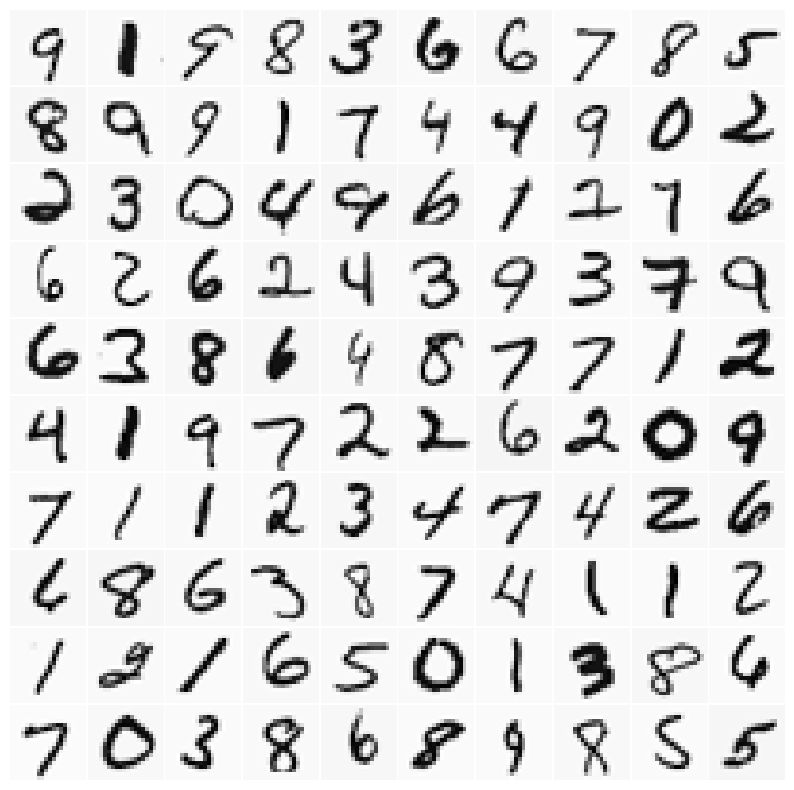

In [12]:
#  training data stored in arrays X, y
data = loadmat("./input/ex3data1.mat")
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

### 2.1 Model representation

In [13]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat("./input/ex3weights.mat")

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

### 2.2 Feed Forward Propagation and Prediction

In [14]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network.
    
    Parameters
    ----------
    Theta1 : array_like
        Weights for the first layer in the neural network.
        It has shape (2nd hidden layer size x input size)
    
    Theta2: array_like
        Weights for the second layer in the neural network. 
        It has shape (output layer size x 2nd hidden layer size)
    
    X : array_like
        The image inputs having shape (number of examples x image dimensions).
    
    Return 
    ------
    p : array_like
        Predictions vector containing the predicted label for each example.
        It has a length equal to the number of examples.
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned neural
    network. You should set p to a vector containing labels 
    between 0 to (num_labels-1).
     
    Hint
    ----
    This code can be done all vectorized using the numpy argmax function.
    In particular, the argmax function returns the index of the  max element,
    for more information see '?np.argmax' or search online. If your examples
    are in rows, then, you can use np.argmax(A, axis=1) to obtain the index
    of the max for each row.
    
    Note
    ----
    Remember, we have supplied the `sigmoid` function in the `utils.py` file. 
    You can use this function by calling `utils.sigmoid(z)`, where you can 
    replace `z` by the required input variable to sigmoid.
    """
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================
    X = np.insert(X, 0, 1, axis=1)
    # X = np.concatenate([np.ones((m, 1)), X], axis=1)
    h_x = utils.sigmoid(Theta1 @ X.T)
    hidden_layer = np.insert(h_x, 0, 1, axis=0) ## 
    output = utils.sigmoid(Theta2 @ hidden_layer)
    p = output.argmax(axis=0).T
    
    # =============================================================
    return p


In [15]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 3


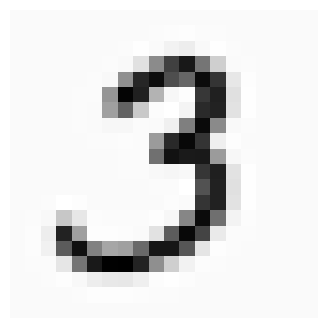

In [16]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')